In [3]:
# Imports and setup

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Set matplotlib style
plt.style.use('ggplot')
%matplotlib inline

# Define paths
DATA_DIR = './data/ISIC2018_Task3_Training_Input'
CSV_FILE = './data/ISIC2018_Task3_Training_GroundTruth.csv'
SEGMENTATION_DIR = './data/segmented_lesions'  
MODEL_SAVE_PATH = './models/skin_lesion_model.keras'
IMG_SIZE = (224, 224)
BATCH_SIZE = 16  

# Create directories
os.makedirs('./models', exist_ok=True)
os.makedirs('./plots', exist_ok=True)
os.makedirs(SEGMENTATION_DIR, exist_ok=True)

In [5]:
# Load and analyze data

Classes: ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
Total images: 10015


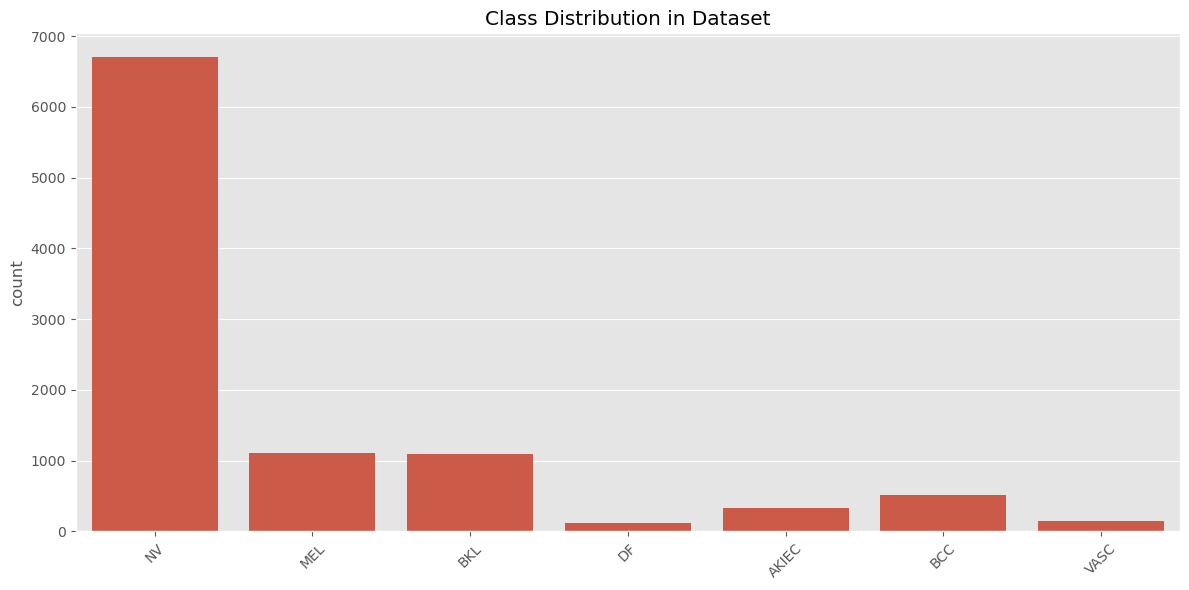

In [7]:
def load_isic_data(data_dir, csv_file):
    """Load ISIC dataset and return image paths and labels"""
    df = pd.read_csv(csv_file)
    image_paths = [os.path.join(data_dir, f"{img_id}.jpg") for img_id in df['image']]
    labels_one_hot = df.iloc[:, 1:].values
    labels = labels_one_hot.argmax(axis=1)
    class_names = df.columns[1:].tolist()
    label_names = [class_names[i] for i in labels]
    return image_paths, labels, label_names, class_names

# Load the data
image_paths, labels, label_names, class_names = load_isic_data(DATA_DIR, CSV_FILE)
print(f'Classes: {class_names}')
print(f'Total images: {len(image_paths)}')

# Plot class distribution
plt.figure(figsize=(12, 6))
sns.countplot(x=label_names)
plt.xticks(rotation=45)
plt.title('Class Distribution in Dataset')
plt.tight_layout()
plt.savefig('./plots/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# U-Net Segmentation Model with VGG16 Encoder (Stage 1)

In [11]:
def create_unet_segmentation_model(input_shape=(224, 224, 3)):
    """Create U-Net model with VGG16 encoder for segmentation"""
    # VGG16 encoder
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze encoder layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Encoder layers
    s1 = base_model.get_layer('block1_conv2').output
    s2 = base_model.get_layer('block2_conv2').output
    s3 = base_model.get_layer('block3_conv3').output
    s4 = base_model.get_layer('block4_conv3').output
    
    # Bridge
    b1 = base_model.get_layer('block5_conv3').output
    
    # Decoder with skip connections
    d1 = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(b1)
    d1 = layers.concatenate([d1, s4])
    d1 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(d1)
    d1 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(d1)
    
    d2 = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(d1)
    d2 = layers.concatenate([d2, s3])
    d2 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(d2)
    d2 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(d2)
    
    d3 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(d2)
    d3 = layers.concatenate([d3, s2])
    d3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(d3)
    d3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(d3)
    
    d4 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(d3)
    d4 = layers.concatenate([d4, s1])
    d4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(d4)
    d4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(d4)
    
    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(d4)
    
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

# Create segmentation model
segmentation_model = create_unet_segmentation_model()
segmentation_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 887s 15us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1 (Conv2D)         │ (None, 224, 224, 64)      │           1,792 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2 (Conv2D)         │ (None, 224, 224, 64)      │          36,928 │ block1_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_pool (MaxPooling2D)    │ (None, 112, 112, 64)      │               0 │ block1_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_conv1 (Conv2D)         │ (None, 112, 112, 128)     │          73,856 │ block1_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_conv2 (Conv2D)         │ (None, 112, 112, 128)     │         147,584 │ block2_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool (MaxPooling2D)    │ (None, 56, 56, 128)       │               0 │ block2_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv1 (Conv2D)         │ (None, 56, 56, 256)       │         295,168 │ block2_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv2 (Conv2D)         │ (None, 56, 56, 256)       │         590,080 │ block3_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv3 (Conv2D)         │ (None, 56, 56, 256)       │         590,080 │ block3_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_pool (MaxPooling2D)    │ (None, 28, 28, 256)       │               0 │ block3_conv3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv1 (Conv2D)         │ (None, 28, 28, 512)       │       1,180,160 │ block3_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv2 (Conv2D)         │ (None, 28, 28, 512)       │       2,359,808 │ block4_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv3 (Conv2D)         │ (None, 28, 28, 512)       │       2,359,808 │ block4_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_pool (MaxPooling2D)    │ (None, 14, 14, 512)       │               0 │ block4_conv3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block5_conv1 (Conv2D)         │ (None, 14, 14, 512)       │       2,359,808 │ block4_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block5_conv2 (Conv2D)         │ (None, 14, 14, 512)       │       2,359,808 │ block5_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 28,025,537 (106.91 MB)

 Trainable params: 13,310,849 (50.78 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
# Create simple masks for training

In [1]:
def create_simple_mask(image_path):
    """Create a simple circular mask approximation for training"""
    img = Image.open(image_path).resize(IMG_SIZE)
    img_array = np.array(img)  # Keep as uint8 (0-255)
    
    # Simple threshold-based mask
    gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)  # Use 127 instead of 0.5
    
    # Convert to float and normalize
    mask = mask.astype(np.float32) / 255.0
    
    # Apply morphological operations to clean up
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    return mask

# Visualize sample masks
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    img_path = image_paths[i]
    
    # Original image
    img = Image.open(img_path).resize(IMG_SIZE)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Original {i}')
    axes[0, i].axis('off')
    
    # Generated mask
    mask = create_simple_mask(img_path)
    axes[1, i].imshow(mask, cmap='gray')
    axes[1, i].set_title(f'Mask {i}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig('./plots/sample_masks.png', dpi=300, bbox_inches='tight')
plt.show()

NameError: name 'plt' is not defined

In [21]:
# Train segmentation model

In [ ]:
def train_segmentation_model(image_paths, epochs=20):
    """Train the segmentation model with generated masks"""
    # Prepare training data - USE ALL IMAGES!
    X_train = []
    y_train = []
    
    print(f"Preparing training data from {len(image_paths)} images...")
    
    for img_path in image_paths:  
        img = Image.open(img_path).resize(IMG_SIZE)
        img_array = np.array(img) / 255.0
        mask = create_simple_mask(img_path)
        
        X_train.append(img_array)
        y_train.append(mask)
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = np.expand_dims(y_train, axis=-1)
    
    print(f"Training data shape: {X_train.shape}")
    print(f"Mask data shape: {y_train.shape}")
    
    # Compile model
    segmentation_model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks for segmentation training
    seg_callbacks = [
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
        ModelCheckpoint('./models/segmentation_best.keras', monitor='val_accuracy', save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, min_lr=1e-7)
    ]
    
    # Train
    print(f"Training segmentation model for {epochs} epochs...")
    history = segmentation_model.fit(
        X_train, y_train,
        batch_size=8,
        epochs=epochs,
        validation_split=0.2,
        callbacks=seg_callbacks,
        verbose=1
    )
    
    return history

seg_history = train_segmentation_model(image_paths, epochs=20) 

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 1889s 18s/step - accuracy: 0.8794 - loss: 0.2907 - val_accuracy: 0.9574 - val_loss: 0.1099
Epoch 2/5
 73/100 ━━━━━━━━━━━━━━━━━━━━ 6:44 15s/step - accuracy: 0.9589 - loss: 0.1012

In [ ]:
# Segment all images and save segmented lesions

In [ ]:
def segment_and_save_images(image_paths, output_dir):
    """Segment all images and save the segmented lesions"""
    segmented_paths = []
    
    for i, img_path in enumerate(image_paths):
        # Load and preprocess image
        img = Image.open(img_path).resize(IMG_SIZE)
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        # Predict mask
        mask = segmentation_model.predict(img_array, verbose=0)[0]
        mask = (mask > 0.5).astype(np.uint8)
        
        # Apply mask to original image
        segmented = img_array[0] * np.repeat(mask, 3, axis=-1)
        
        # Save segmented image
        img_name = os.path.basename(img_path)
        output_path = os.path.join(output_dir, img_name)
        segmented_img = Image.fromarray((segmented * 255).astype(np.uint8))
        segmented_img.save(output_path)
        segmented_paths.append(output_path)
        
        if i % 500 == 0:
            print(f"Processed {i}/{len(image_paths)} images")
    
    return segmented_paths

# Segment all images
print("Segmenting images...")
segmented_paths = segment_and_save_images(image_paths, SEGMENTATION_DIR)
print("Segmentation completed!")